<a id='Data_loading_structure'></a>
# 1. Data Loading and Structure

Loading data dan melihat struktur dari data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab import files

import os

Dataset sudah dibagi kedalam masing-masing folder "train", "test", dan "val".

In [ ]:

# Exploring dataset
from google.colab import drive
drive.mount('/content/drive')

import os
data_dir = '/content/drive/MyDrive/Coba/Image/chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Mounted at /content/drive
['train', 'test', 'val', 'train1', 'test1']
['PNEUMONIA', 'NORMAL']


In [ ]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3875
['person597_bacteria_2450.jpeg', 'person586_bacteria_2417.jpeg', 'person557_bacteria_2327.jpeg', 'person534_bacteria_2252.jpeg', 'person568_bacteria_2358.jpeg']


In [ ]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1346
['IM-0519-0001-0001.jpeg', 'IM-0528-0001.jpeg', 'IM-0539-0001.jpeg', 'IM-0530-0001.jpeg', 'IM-0549-0001-0002.jpeg']


Karena di sini akan menggunakan library PyTorch maka dataset perlu diubah menjadi tensor. Untuk melakukannya gambar tidak dimuat sekaligus oleh komputer karena akan memakan memori yang banyak.

Dataset PyTorch juga memungkinkan untuk menentukan satu atau lebih fungsi transformasi yang akan diterapkan pada gambar saat dimuat. torchvision.transforms berisi banyak fungsi transformasi yang telah ditentukan sebelumnya. Di sini  akan diterapkan transformasi berikut:
1. Mengubah ukuran dan memotong gambar menjadi 224x224 karena banyak gambar memiliki ukuran yang berbeda. Ini dilakukan sebelum potongan tengah untuk memastikan bahwa gambar memiliki ukuran yang sama sebelum dipotong.
2. Pemotongan gambar dari titik tengah (center crop). untuk menghasilkan gambar berukuran yang konsisten.
3. Augmentasi Data: flip horizontal acak, rotasi acak, dan konversi acak ke skala keabuan. Horizontal flip dilakukan pembalikan horizontal acak pada gambar dengan peluang 50%. Ini menambah variasi data dengan mempertahankan label yang sama.
4. RandomRotation Melakukan rotasi acak pada gambar hingga 10 derajat ke kiri atau ke kanan.
5. RandomGrayscale(): Mengubah gambar menjadi skala keabuan secara acak dengan peluang 50%.
6. RandomAffine(translate=(0.05,0.05), degrees=0): Melakukan transformasi afine acak pada gambar dengan menggeser gambar secara acak sebesar 5% dari lebar dan tinggi gambar, tanpa rotasi.
7. ToTensor(): Mengonversi gambar menjadi tensor PyTorch.

Lebih lanjut tentang augmentasi data:

Augmentasi data adalah strategi yang memungkinkan praktisi untuk meningkatkan signifikan keragaman data yang tersedia untuk melatih model, tanpa harus mengumpulkan data baru. Teknik augmentasi data seperti pemotongan, padding, dan pembalikan horizontal umumnya digunakan untuk melatih jaringan saraf besar. Perlu dicatat bahwa augmentasi data yang dilakukan di sini hanya meningkatkan keragaman dengan memperkenalkan perubahan acak dari gambar asli, tetapi TIDAK MENINGKATKAN jumlah gambar/sampel dalam dataset.


In [ ]:
# Fungsi untuk memeriksa jenis gambar
def check_image_type(image_path):
    # Membaca gambar menggunakan OpenCV
    image = cv2.imread(image_path)
    if image is None:
        return "Failed"  # Menandakan bahwa pembacaan gambar gagal
    # Memeriksa jumlah saluran warna jika gambar berhasil dibaca
    num_channels = image.shape[2] if len(image.shape) == 3 else 1
    if num_channels == 3:
        return "RGB"
    elif num_channels == 1:
        return "Grayscale"
    else:
        return "Tidak dikenali"

# Menghitung jumlah gambar RGB dan grayscale untuk setiap kelas
num_rgb_normal = 0
num_grayscale_normal = 0
num_failed_normal = 0
num_rgb_pneumonia = 0
num_grayscale_pneumonia = 0
num_failed_pneumonia = 0

# Memeriksa gambar dalam folder NORMAL
normal_folder = os.path.join(data_dir, "train", "NORMAL")
for filename in os.listdir(normal_folder):
    image_path = os.path.join(normal_folder, filename)
    image_type = check_image_type(image_path)
    if image_type == "RGB":
        num_rgb_normal += 1
    elif image_type == "Grayscale":
        num_grayscale_normal += 1
    elif image_type == "Failed":
        num_failed_normal += 1

# Memeriksa gambar dalam folder PNEUMONIA
pneumonia_folder = os.path.join(data_dir, "train", "PNEUMONIA")
for filename in os.listdir(pneumonia_folder):
    image_path = os.path.join(pneumonia_folder, filename)
    image_type = check_image_type(image_path)
    if image_type == "RGB":
        num_rgb_pneumonia += 1
    elif image_type == "Grayscale":
        num_grayscale_pneumonia += 1
    elif image_type == "Failed":
        num_failed_pneumonia += 1

# Mencetak jumlah gambar RGB dan grayscale untuk setiap kelas
print("Jumlah gambar RGB pada kelas NORMAL:", num_rgb_normal)
print("Jumlah gambar Grayscale pada kelas NORMAL:", num_grayscale_normal)
print("Jumlah gambar yang gagal dibaca pada kelas NORMAL:", num_failed_normal)
print("Jumlah gambar RGB pada kelas PNEUMONIA:", num_rgb_pneumonia)
print("Jumlah gambar Grayscale pada kelas PNEUMONIA:", num_grayscale_pneumonia)
print("Jumlah gambar yang gagal dibaca pada kelas PNEUMONIA:", num_failed_pneumonia)


Jumlah gambar RGB pada kelas NORMAL: 1346
Jumlah gambar Grayscale pada kelas NORMAL: 0
Jumlah gambar yang gagal dibaca pada kelas NORMAL: 0
Jumlah gambar RGB pada kelas PNEUMONIA: 3875
Jumlah gambar Grayscale pada kelas PNEUMONIA: 0
Jumlah gambar yang gagal dibaca pada kelas PNEUMONIA: 0


In [ ]:
dataset = ImageFolder(data_dir+'/train',
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                           ]))
dataset

Dataset ImageFolder
    Number of datapoints: 5221
    Root location: /content/drive/MyDrive/Coba/Image/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

Sampel gambar setelah dimuat dalam bentuk tensor. setiap gambar sekarang berbentuk [3, 224, 224], dengan 3 menjadi saluran RGB.

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [ ]:
num_rgb = 0
num_grayscale = 0

# Iterasi melalui dataset
for image, label in dataset:
    # Memeriksa dimensi tensor
    if image.shape[0] == 3:
        num_rgb += 1
    elif image.shape[0] == 1:
        num_grayscale += 1
    else:
        print("Dimensi pertama tensor bukan 3 atau 1. Mungkin ada kesalahan dalam pemrosesan gambar.")

print("Jumlah gambar RGB:", num_rgb)
print("Jumlah gambar grayscale:", num_grayscale)


Jumlah gambar RGB: 5221
Jumlah gambar grayscale: 0


In [ ]:
# Ambil contoh gambar RGB dari dataset
rgb_image, label = dataset[0]

# Pastikan gambar adalah gambar RGB
if rgb_image.shape[0] == 3:
    # Akses nilai piksel pada gambar
    red_channel = rgb_image[0]  # Saluran warna merah (Red)
    green_channel = rgb_image[1]  # Saluran warna hijau (Green)
    blue_channel = rgb_image[2]  # Saluran warna biru (Blue)

    # Cetak nilai rata-rata untuk setiap saluran warna
    print("Nilai rata-rata saluran warna merah (Red):", red_channel.mean().item())
    print("Nilai rata-rata saluran warna hijau (Green):", green_channel.mean().item())
    print("Nilai rata-rata saluran warna biru (Blue):", blue_channel.mean().item())
else:
    print("Gambar bukan gambar RGB.")


Nilai rata-rata saluran warna merah (Red): 0.5479856729507446
Nilai rata-rata saluran warna hijau (Green): 0.5479856729507446
Nilai rata-rata saluran warna biru (Blue): 0.5479856729507446


Memeriksa kelas pada dataset

In [ ]:
print(dataset.classes)

['NORMAL', 'PNEUMONIA']


In [ ]:
# Jumlah gambar NORMAL

len([os.path.join(data_dir+'/train/NORMAL', filename)
                        for filename in os.listdir(data_dir+'/train/NORMAL')])

1346

In [ ]:
# Jumlah gambar PNEUMONIA

len([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])

3875

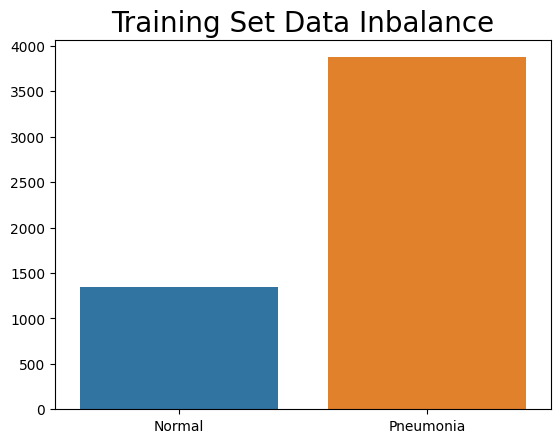

In [ ]:
# Jumlah gambar masing-masing kelas

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename)
                     for filename in os.listdir(data_dir+'/train/NORMAL')])],
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()


Indonesia:

Terlihat ada ketidakseimbangan kelas data dalam dataset kita, dengan gambar pneumonia memiliki lebih banyak sampel dibandingkan dengan gambar normal. Ini merupakan masalah karena akan menjadi lebih sulit bagi model untuk melakukan generalisasi dengan baik karena model mungkin akan menjadi overfitted terhadap kelas dominan selama pelatihan dan akibatnya akan berperforma buruk ketika melihat dataset baru. Saya akan mencoba untuk mengompensasi hal ini dengan memberikan bobot yang berbeda pada kerugian (loss) dari setiap kelas/label. Ini berarti untuk gambar normal, mereka akan diberikan bobot yang lebih tinggi saat mengevaluasi kerugian, dan gambar pneumonia akan diberikan bobot yang lebih rendah.

Label:  NORMAL (0)


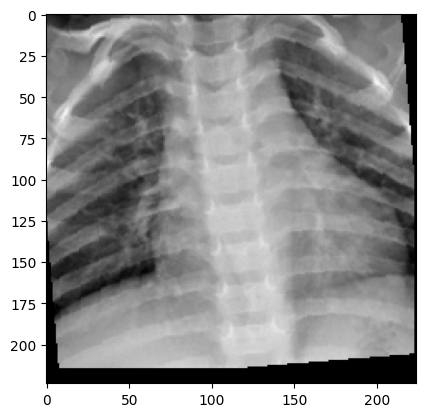

In [ ]:
# Menampilkan sampel gambar

import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[4])

Menampilkan sampel gambar beserta klasifikasi kelas masing-masing

In [ ]:

# Function for plotting samples
def plot_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

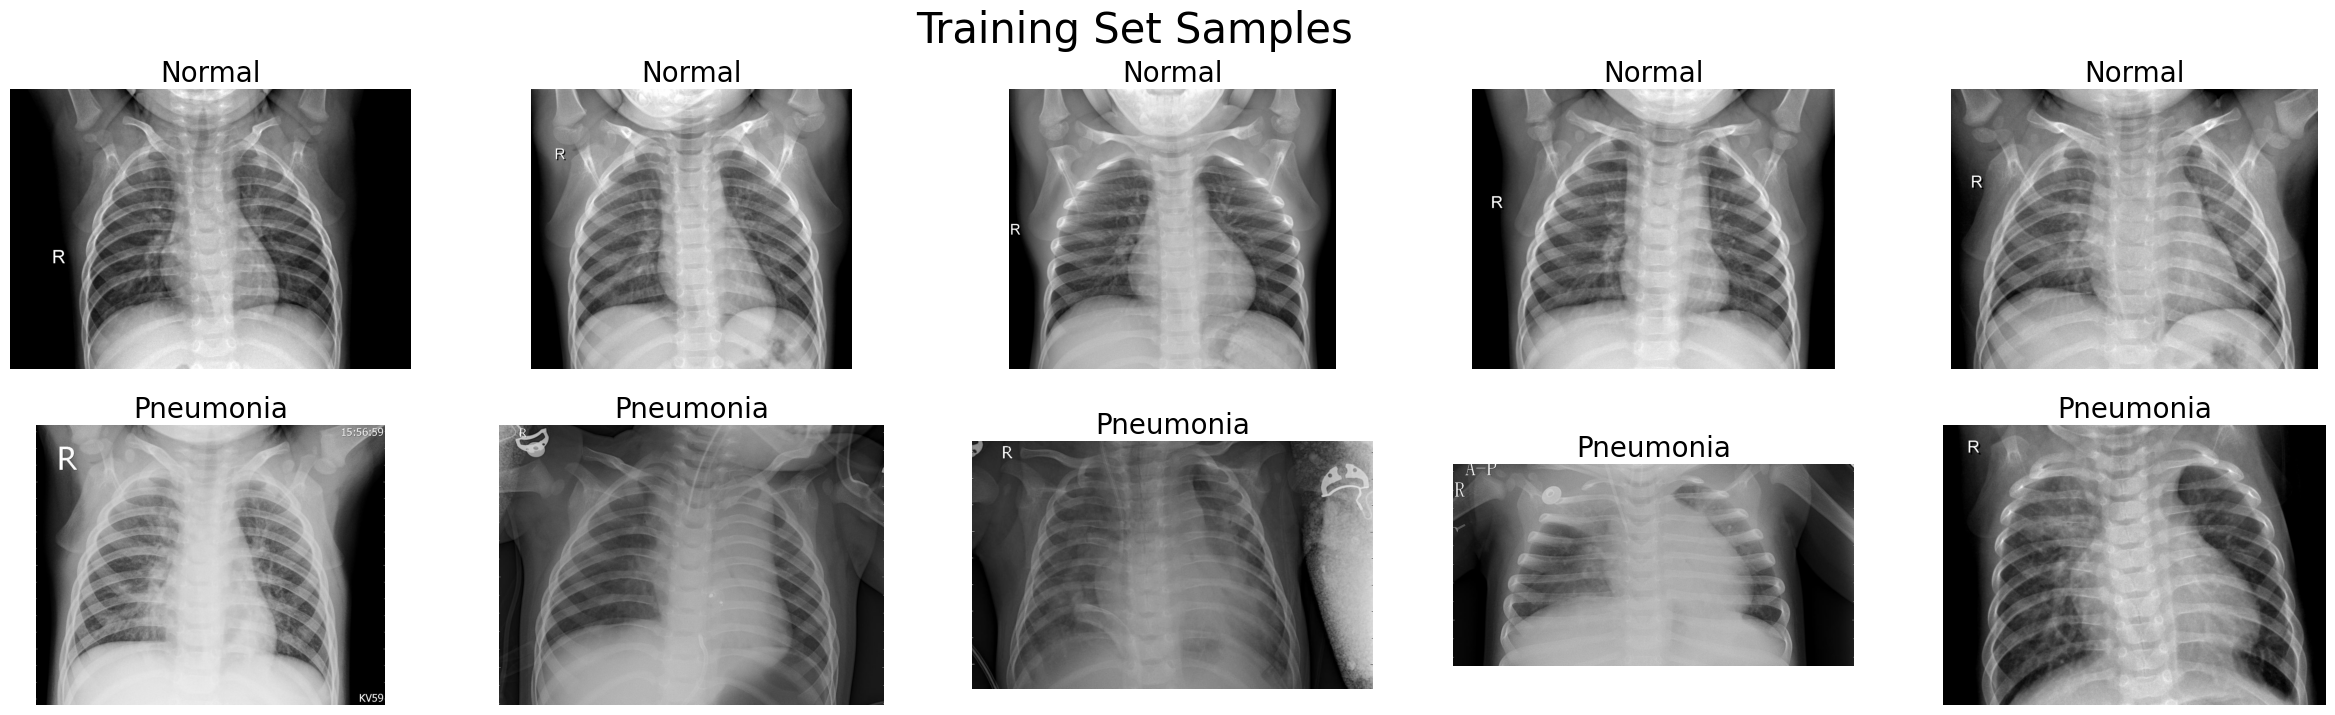

In [ ]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename)
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename)
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

<a id='Preparing_data'></a>
# 2. Preparing Train, Validation & Test Data

Sekarang saatnya untuk menyiapkan dataset pelatihan, validasi, dan pengujian kita. Kami melakukannya menggunakan fungsi random_split di torch. Di sini kami membagi dataset pelatihan menjadi 80% pelatihan dan 20% validasi. Perlu diperhatikan bahwa PyTorch tidak memiliki fungsi bawaan untuk pengambilan sampel stratified, yang berarti setiap sampel akan memiliki proporsi kelas yang sama seperti aslinya.

Dataset train: digunakan untuk melatih model yaitu menghitung kerugian dan menyesuaikan bobot model menggunakan gradien descent.
Dataset validation: digunakan untuk mengevaluasi model saat pelatihan, menyesuaikan hiperparameter (tingkat pembelajaran, dll.), dan memilih versi terbaik dari model.
Dataset test: digunakan untuk membandingkan berbagai model, atau berbagai jenis pendekatan pemodelan, dan melaporkan akurasi akhir dari model.
Dengan demikian, dataset dipisahkan menjadi tiga bagian ini untuk digunakan dalam proses pelatihan, validasi, dan pengujian.

Menetapkan random seed untuk memastikan bahwa kita mendapatkan sampel yang sama setiap kali proses pengambilan sampel dilakukan. Hal ini dilakukan untuk mendapatkan hasil yang konsisten dan dapat direproduksi pada setiap eksekusi program.

Pengaturan random seed ini memastikan bahwa proses pembagian dataset menjadi dataset pelatihan, validasi, dan pengujian dilakukan dengan cara yang sama setiap kali kode dieksekusi, sehingga memungkinkan hasil yang konsisten saat melakukan eksperimen atau membandingkan model.

In [ ]:
# Atur random_seed agar  mendapatkan pengambilan sampel yang sama setiap kali untuk reproduktibilitas.

random_seed = 2020
torch.manual_seed(random_seed);

Karena data awal lebih banyak Pneumonia daripada data Normal, maka jika dilakukan random_split bisa jadi hasil untuk data train atau validation memiliki data yang tidak merepresentasikan distribusi data awal. misal data train mayoritas data pneumonia, sedangkan validation mayoritas data normal.

hal ini dapat diatasi dengan metode stratified split, sehingga dapat mempertahankan representasi distribus data. akan tetapi untuk library pytorch tidak tersedia, jadi bisa dilakukan manual atau menggunakan library scikit learn untuk menerapkan metode tersebut.

akan tetapi pada notebook ini dianggap bahwa distribusi akan tetap sama, karena jauhnya perbedaan dist

In [ ]:
# Membagi dataset train menjadi 80% train dan 20% validation

train_size = round(len(dataset)*0.8) # 80%
val_size = len(dataset) - train_size # 20%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(4177, 1044)

Indonesia


Di sini kita memilih ukuran batch sebesar 128 untuk melakukan mini-batch gradient descent atau optimisasi lainnya. Ini adalah hiperparameter yang dapat disesuaikan. Ukuran batch berarti bahwa 3651 gambar pelatihan akan dibagi menjadi batch-batch berukuran 128 gambar dan gradien descent akan dilakukan pada setiap dari 128 gambar ini dalam satu epok (satu putaran penuh dari seluruh data).

Mengubah num_workers=2 untuk melakukan efisiensi kinerja komputer

In [ ]:
# Membuat dataloader dari data train dan validation, serta melakukan penanda pada memory GPU yang nanti akan digunakan pelatihan model

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


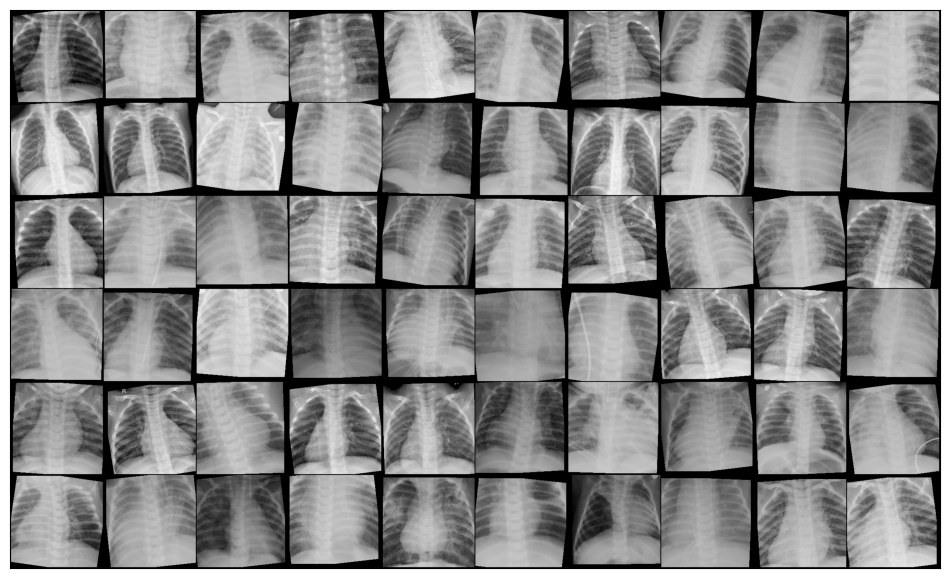

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break

show_batch(train_dl)

<a id='GPU'></a>
# 3. Set Up GPU



Memeriksa apakah GPU tersedia dan driver NVIDIA CUDA yang diperlukan telah diinstal menggunakan torch.cuda.is_available.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Melakukan definisi GPU yang digunakan jika ada, jika tidak maka menggunakan CPU

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
# Melakukan definisi untuk nantinya memindahkan dataset yang berbentuk tensor sebelumnya ke dalam GPU/CPU yang tersedia

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

Mendefinisikan kelas DeviceDataLoader yang bertujuan untuk membungkus data loader yang sudah ada dan memindahkan data ke perangkat GPU/CPU yang tersedia

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

<a id='ModelClass'></a>
# 4. Creating Model Class

Membuat kelas untuk inisialiasi pembuatan model

In [ ]:
# membuat beberapa fungsi untuk menghitung metrik kinerja model

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1)

    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))

    return precision,recall,f1,preds

membuat kelas model dasar dengan fungsi-fungsi yang akan dipanggil dengan kelas model utama.

* **training_step**: untuk memuat batch gambar pelatihan dan mengeluarkan kerugiannya dan akurasinya. Output digunakan untuk menghitung gradien dan untuk digabungkan dengan batch lainnya nanti.
* **train_epoch_end**: ini digunakan untuk menggabungkan akurasi dan kerugian dari semua batch dalam setiap epoch untuk dicetak.
* **validation_step**: sama seperti training_step, tetapi untuk gambar validasi dan pengujian.
* **validation_epoch_end**: sama seperti train_epoch_end, tetapi untuk gambar validasi.
* **epoch_end**: ini mengambil semua output dari train_epoch_end dan validation_epoch_end dan mencetak kinerja epoch.
* **test_prediction**: untuk prediksi pada gambar uji dan mengembalikan kinerja, label, dan prediksi.

In [ ]:
class PneumoniaModelBase(nn.Module):

    # this is for loading the batch of train image and outputting its loss, accuracy
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy

        return {'train_loss': loss, 'train_acc':acc}

    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies

        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}

    # this is for loading the batch of val/test image and outputting its loss, accuracy,
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds

        return {'val_loss': loss.detach(), 'val_acc':acc.detach(),
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory

    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))

    # this is for using on the test set, it outputs the average loss and acc,
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()]
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]

        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}

### ResNet


Jaringan Residual (Residual Network) sama seperti arsitektur jaringan saraf konvolusional (CNN) lainnya, kecuali bahwa mereka menggunakan blok residual. Ini menambahkan input asli kembali ke peta fitur output yang diperoleh dengan melewati input melalui satu atau lebih lapisan konvolusional.

<img src = 'https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png' width="400">

<br>

Perubahan kecil ini menghasilkan peningkatan kinerja yang drastis. Ini memungkinkan pelatihan jaringan yang lebih dalam tanpa merusak kinerja karena beberapa lapisan dapat dilewati (blok residual juga disebut sebagai koneksi lewati). Anda dapat merujuk ke blogpost ini untuk memahami lebih baik bagaimana ResNet bekerja:
https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

In [ ]:
# Memeriksa ketersediaan ResNet50 pada PyTorch

resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


muat model ResNet50 dan inspeksinya. ni memiliki 48 lapisan konvolusi bersama dengan 1 lapisan MaxPool dan 1 lapisan Average Pool.

Catatan bahwa jaringan memiliki lapisan AdaptiveAvgPool2d. Ini memungkinkan kita untuk memasukkan gambar dengan ukuran apa pun ke dalam model.

In [ ]:
from torchsummary import summary

# Menampilkan summary arsitektur ResNet50
summary(resnet50.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<img src = 'https://www.researchgate.net/publication/331364877/figure/fig3/AS:741856270901252@1553883726825/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png' width="600">

<br>

From [Ji et al.(2019)](https://www.researchgate.net/publication/331364877_Optimized_Deep_Convolutional_Neural_Networks_for_Identification_of_Macular_Diseases_from_Optical_Coherence_Tomography_Images)

Membuat kelas untuk menyiapkan model.

Di dalam metode konstruktor init, memuat model ResNet50, mengatur parameter pretrained menjadi true untuk memuat bobot yang telah dilatih sebelumnya. Kemudian membekukan lapisan awal dari jaringan (kecuali fully connected (fc) layer) dan mengganti lapisan terakhir (fc) dengan lapisan sendiri karena output pada kasus ini hanya memiliki 2 kelas, sedangkan ResNet50 dilatih untuk mengeluarkan 1000 kelas (lihat model di atas).

Selain itu juga dilakukan penambahan layer pada akhir arsitektur terdiri dari
- lapisan linier tambahan
- Fungsi aktivasi ReLU
- Fully Connected layer akhir

Metode forward dipanggil saat melewatkan batch input ke model.

In [ ]:

# Menggunakan model ResNet50 dari torchvision
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Gunakan pretrained ResNet50
        self.network = models.resnet50(pretrained=True)

        # Ganti lapisan linear terakhir ResNet50 dengan lapisan linear baru
        num_features = self.network.fc.in_features
        self.network.fc = nn.Linear(num_features, 256)  # Ubah output menjadi 256

        # Tambahkan lapisan linear tambahan dan lapisan dropout
        self.fc = nn.Sequential(
            nn.BatchNorm1d(256), # Batch normalization layer
            nn.ReLU(inplace=True),
            nn.Dropout( 0.5 ),                # Lapisan dropout dengan probabilitas 50%
            nn.Linear(256, 2)
        )

    def forward(self, xb):
        x = self.network(xb)
        x = self.fc(x)
        return x


Berikut adalah definisi fungsi pembantu untuk menyesuaikan dan mengevaluasi model:

- evaluate: fungsi ini hanya memanggil fungsi validasi yang telah kita tentukan sebelumnya dalam kelas model dasar di atas dan mengembalikan outputnya. Fungsi ini dipanggil di dalam fungsi fit.
- get_lr: untuk mendapatkan laju pembelajaran setiap epoch, sehingga kita dapat menyimpannya jika menggunakan penjadwal laju pembelajaran, untuk melacak perubahan.
- fit: ini adalah fungsi utama untuk menyesuaikan model. Kita memberikan model kita dan dataloader serta parameter hiper lainnya.
- model.eval(): mengatur lapisan-lapisan tertentu seperti dropout dan batchnorm ke mode evaluasi (dropout tidak akan menurunkan aktivasi, batchnorm akan menggunakan estimasi berjalan alih-alih statistik batch) sementara model.train() akan mengaktifkannya.
- torch.no_grad(): memengaruhi mesin autograd dan menonaktifkannya. Ini akan mengurangi penggunaan memori dan mempercepat komputasi.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}

    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):

        # Training Phase
        model.train()
        train_outputs = []
        lrs = []

        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']                          # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)
            loss.backward()                                       # compute gradients

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()                                      # update weights
            optimizer.zero_grad()                                 # reset gradients

        # Validation phase
        val_results = evaluate(model, val_loader)

        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')

        # print results
        model.epoch_end(epoch, train_results, val_results)

        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}

        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]

    model.load_state_dict(best_model_wts)                         # load best model

    return history, optimizer, best_loss

<a id='Train_model'></a>
# 5. Train and Evaluate Model

Memastikan kembali bahwa dataloader untuk data pelatihan dan validasi juga berada di perangkat yang sama dengan model (CPU atau GPU)

Memindahkan model ke perangkat yang sama dengan menggunakan fungsi to_device. Dengan melakukan ini, dapat memastikan bahwa seluruh operasi pelatihan dan evaluasi dilakukan di perangkat yang sama,

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

Melatih dan mengevaluasi model

Parameter yang digunakan:
- epochs : Jumlah iterasi lengkap melalui seluruh dataset yang akan digunakan dalam pelatihan model. Setiap iterasi ini disebut sebagai satu epoch.
- lr : Laju pembelajaran (learning rate), yang merupakan seberapa besar langkah yang diambil pada setiap iterasi saat mengoptimalkan parameter model.
- grad_clip : Batas maksimum nilai absolut dari gradien. Jika None, maka tidak ada kliping gradien yang diterapkan.
- weight_decay : Pembusukan bobot (weight decay), yang merupakan penalti yang diberikan pada bobot model untuk mencegah overfitting. Nilai ini menentukan seberapa cepat bobot menurun selama pelatihan.
- opt_func = torch.optim.Adam: Fungsi pengoptimal (optimizer) yang digunakan untuk mengoptimalkan parameter model. Dalam hal ini, menggunakan algoritma Adam yang dikenal efisien dan efektif dalam melatih model.
- weight: Bobot untuk menangani ketidakseimbangan kelas data. Dalam kasus ini, bobot dihitung berdasarkan proporsi kelas masing-masing untuk mengatasi ketidakseimbangan kelas pada data.

In [ ]:
epochs = 23
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3875/(1346+3875), 1346/(1346+3875)]).to(device)


In [ ]:
# Proses pelatihan dilihat dari jumlah iterasi dan durasi

import time

start_time = time.time()

history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight,
                                    grad_clip=grad_clip,
                                    weight_decay=weight_decay,
                                    opt_func=opt_func)
end_time = time.time()
execution_time = end_time - start_time

print("Waktu eksekusi:", execution_time, "detik")

Epoch [1], train_loss: 0.0420, train_acc: 0.9878, val_loss: 0.0680, val_acc: 0.9773
Epoch [2], train_loss: 0.0377, train_acc: 0.9868, val_loss: 0.0812, val_acc: 0.9742
Epoch [3], train_loss: 0.0246, train_acc: 0.9910, val_loss: 0.0580, val_acc: 0.9805
Epoch [4], train_loss: 0.0197, train_acc: 0.9934, val_loss: 0.0536, val_acc: 0.9836
Epoch [5], train_loss: 0.0187, train_acc: 0.9939, val_loss: 0.0821, val_acc: 0.9766
Epoch [6], train_loss: 0.0129, train_acc: 0.9962, val_loss: 0.1100, val_acc: 0.9666
Epoch [7], train_loss: 0.0214, train_acc: 0.9942, val_loss: 0.0362, val_acc: 0.9859
Epoch [8], train_loss: 0.0287, train_acc: 0.9909, val_loss: 0.0482, val_acc: 0.9852
Epoch [9], train_loss: 0.0321, train_acc: 0.9878, val_loss: 0.0675, val_acc: 0.9773
Epoch [10], train_loss: 0.0151, train_acc: 0.9948, val_loss: 0.0327, val_acc: 0.9914
Epoch [11], train_loss: 0.0143, train_acc: 0.9957, val_loss: 0.0585, val_acc: 0.9736
Epoch [12], train_loss: 0.0109, train_acc: 0.9967, val_loss: 0.0370, val_a

In [ ]:
# Nilai Best Loss

print('Best loss is:', best_loss)

Best loss is: 0.031081808730959892


In [ ]:
# Untuk mendownload keseluruhan model
torch.save(model, 'PneumoniaCNN_DNW.pth')

In [ ]:
# Download file model
files.download('PneumoniaCNN_DNW.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# untuk load model yang sebelumnya sudah disimpan

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('./PneumoniaCNN_DNW.pth')

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<a id='Accuracy_loss_plots'></a>
# 6. Accuracy and Loss Plots

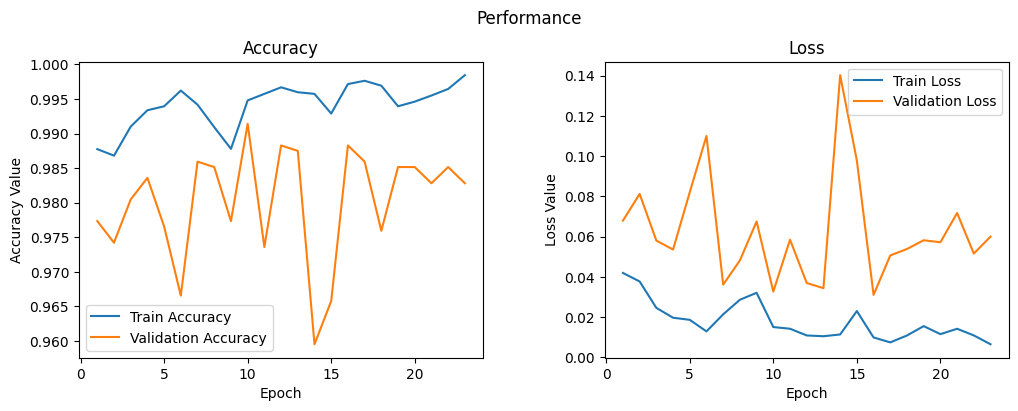

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot Accuracy and Loss

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

# Simpan grafik sebagai file gambar
plt.savefig('performance_plot_DNW_1.png')

# Tampilkan plot
plt.show()

# Download file gambar
files.download('performance_plot_DNW_1.png')

<a id='Predict_test'></a>
# 7. Predicting on Test Set

melihat seberapa baik kinerja model pada data yang belum pernah dilihat sebelumnya.

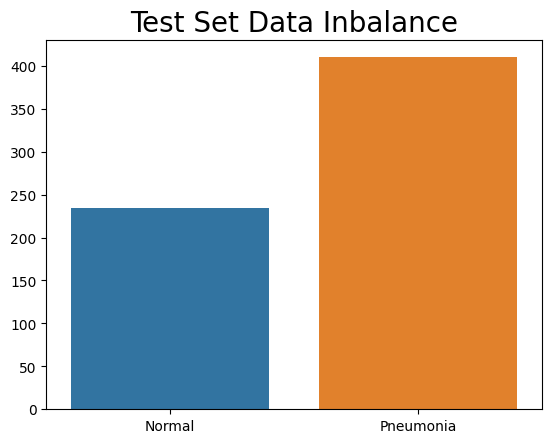

In [ ]:
# Load data test dan memeriksa jumlah data test pada masing-masing kelas

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename)
                     for filename in os.listdir(data_dir+'/test/NORMAL')])],
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename[0:10])
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [ ]:
# Jumlah gambar Normal pada data test

[len([os.path.join(data_dir+'/test/NORMAL', filename)
                     for filename in os.listdir(data_dir+'/test/NORMAL')])]

[234]

In [ ]:
# Jumlah gambar Pneumonia pada data test

[len([os.path.join(data_dir+'/test/PNEUMONIA', filename)
                     for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]

[410]

In [ ]:
# Mendefinsikan test_predict untuk mendapatkan nilai test_loss dan test_acc (test accuracy)

@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader]
    results = model.test_prediction(outputs)
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))

    return results['test_preds'], results['test_labels']

In [ ]:
# Mengatur gambar pada data test seperti pada train dan validation sebelumnya, dengan melakukan Resize, CenterCrop, dan mengubah format ke tensor

test_dataset = ImageFolder(data_dir+'/test',
                           transform=tt.Compose([tt.Resize(224),
                                                 tt.CenterCrop(224),
                                                 tt.ToTensor()
                                                ]))

In [ ]:
# Memeriksa hasil nilai test_loss dan test_acc

test_dl = DataLoader(test_dataset, batch_size=128)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.1550, test_acc: 0.9544


<a id='Evaluation_metrics'></a>
# 8. Model Evaluation Metrics


Menguji seberapa baik kinerja model dengan mengevaluasi beberapa metrik dari prediksi terhadap label target yang sebenarnya.

Akurasi bukanlah metrik evaluasi yang baik ketika terdapat ketimpangan kelas data yang besar. Bayangkan jika memiliki 100 sampel: 99 pneumonia dan 1 normal, maka sebuah model yang memprediksi semua sebagai pneumonia akan mendapatkan akurasi sebesar 99%. Dalam kasus ini, mungkin lebih baik untuk melihat presisi dan recall, serta nilai harmonik keduanya, yaitu skor F1.

Ini dapat divisualisasikan menggunakan confusion matrix.

<img src = 'https://bk9zeg.bn.files.1drv.com/y4mZtoVgcWgAYE59g3lpWQ3PaZWMqnDN7gz1ir2LIgyPjR6a26Ij1vDBmjsETpEmvAkebvyLjSVofcRVSjW8Ux62r8_tIyIK6AZJ7GQOz_sWtAj_hdQIA57pbJaEpHJEeY_pG7odhdU1osvM7jHXfFzpVsIOt76oqNe39j4KZIFRDOguHUr5jPtDe0TIzNTLQuehcuQdw-aIjt7FR9D6Ti9-A?width=618&height=419&cropmode=none' width="600">

<Figure size 640x480 with 0 Axes>

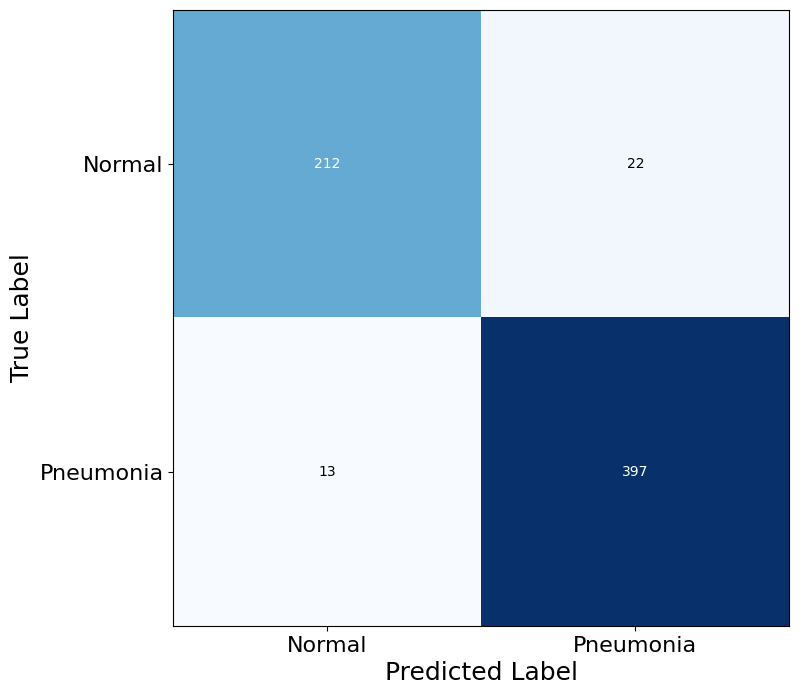

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)


# Simpan confusion matrix sebagai file gambar
plt.savefig('confusion_matrix_DNW_1.png')

# Tamplikan confusion matrix
plt.show()

# Download file gambar
files.download('confusion_matrix_DNW_1.png')

Menampilkan nilai Akurasi, Recall, Presisi, dan F1 Score

In [ ]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.95
Recall of the model is 0.97
Precision of the model is 0.95
F1 Score of the model is 0.96


Menampilkan Kurva ROC dan nilai ROC-AUC

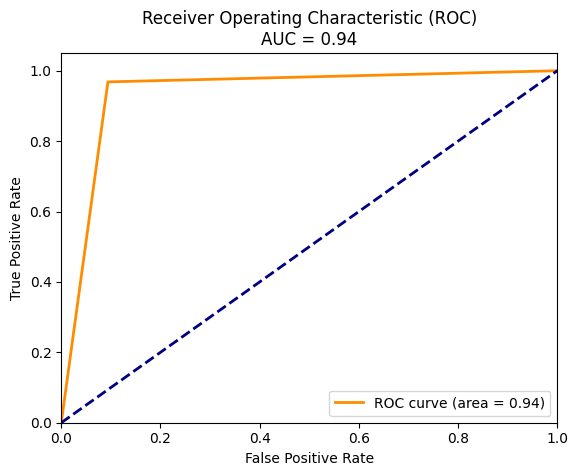

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import roc_curve, auc

# Atur model ke mode evaluasi
model.eval()

preds_tensor = torch.tensor(preds)
# Konversi tipe data prediksi menjadi float sebelum menerapkan sigmoid
preds_tensor_float = preds_tensor.float()

# Hitung probabilitas positif menggunakan sigmoid
probs_positive = torch.sigmoid(preds_tensor_float)

def calculate_roc_auc(labels, probs_positive):
    # Konversi labels menjadi tensor PyTorch
    labels_tensor = torch.tensor(labels)

    # Mengonversi probabilitas PyTorch ke dalam NumPy array
    probs_positive_np = probs_positive.cpu().detach().numpy()

    # Menggunakan metode roc_curve dari NumPy atau paket lain yang cocok
    fpr, tpr, _ = roc_curve(labels_tensor, probs_positive_np)

    # Menghitung AUC
    roc_auc = np.trapz(tpr, fpr)

    return fpr, tpr, roc_auc

# Memanggil fungsi untuk menghitung kurva ROC dan AUC
fpr, tpr, roc_auc = calculate_roc_auc(labels, probs_positive)

# Plot kurva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)\nAUC = %0.2f' % roc_auc)  # Tambahkan nilai AUC ke judul grafik
plt.legend(loc="lower right")

# Simpan grafik sebagai file gambar di dalam Colab
plt.savefig('/content/roc_curve_with_auc_DNW_1.png')

# Tampilkan grafik
plt.show()

# Unduh file gambar
files.download('/content/roc_curve_with_auc_DNW_1.png')


In [ ]:
import numpy as np

# Simpan nilai false positive rate, true positive rate, dan AUC ke dalam file teks
np.savetxt('roc_curve_data.txt', np.column_stack((fpr, tpr)), delimiter='\t', header='False Positive Rate\tTrue Positive Rate')
with open('auc.txt', 'w') as file:
    file.write(str(roc_auc))


In [ ]:
# Download file ROC curve data
files.download('roc_curve_data.txt')

# Download file AUC
files.download('auc.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a id='Plot_predictions'></a>
# 9. Plot Predictions against Actual Labels

Mencoba melakukan prediksi dari dataset baru

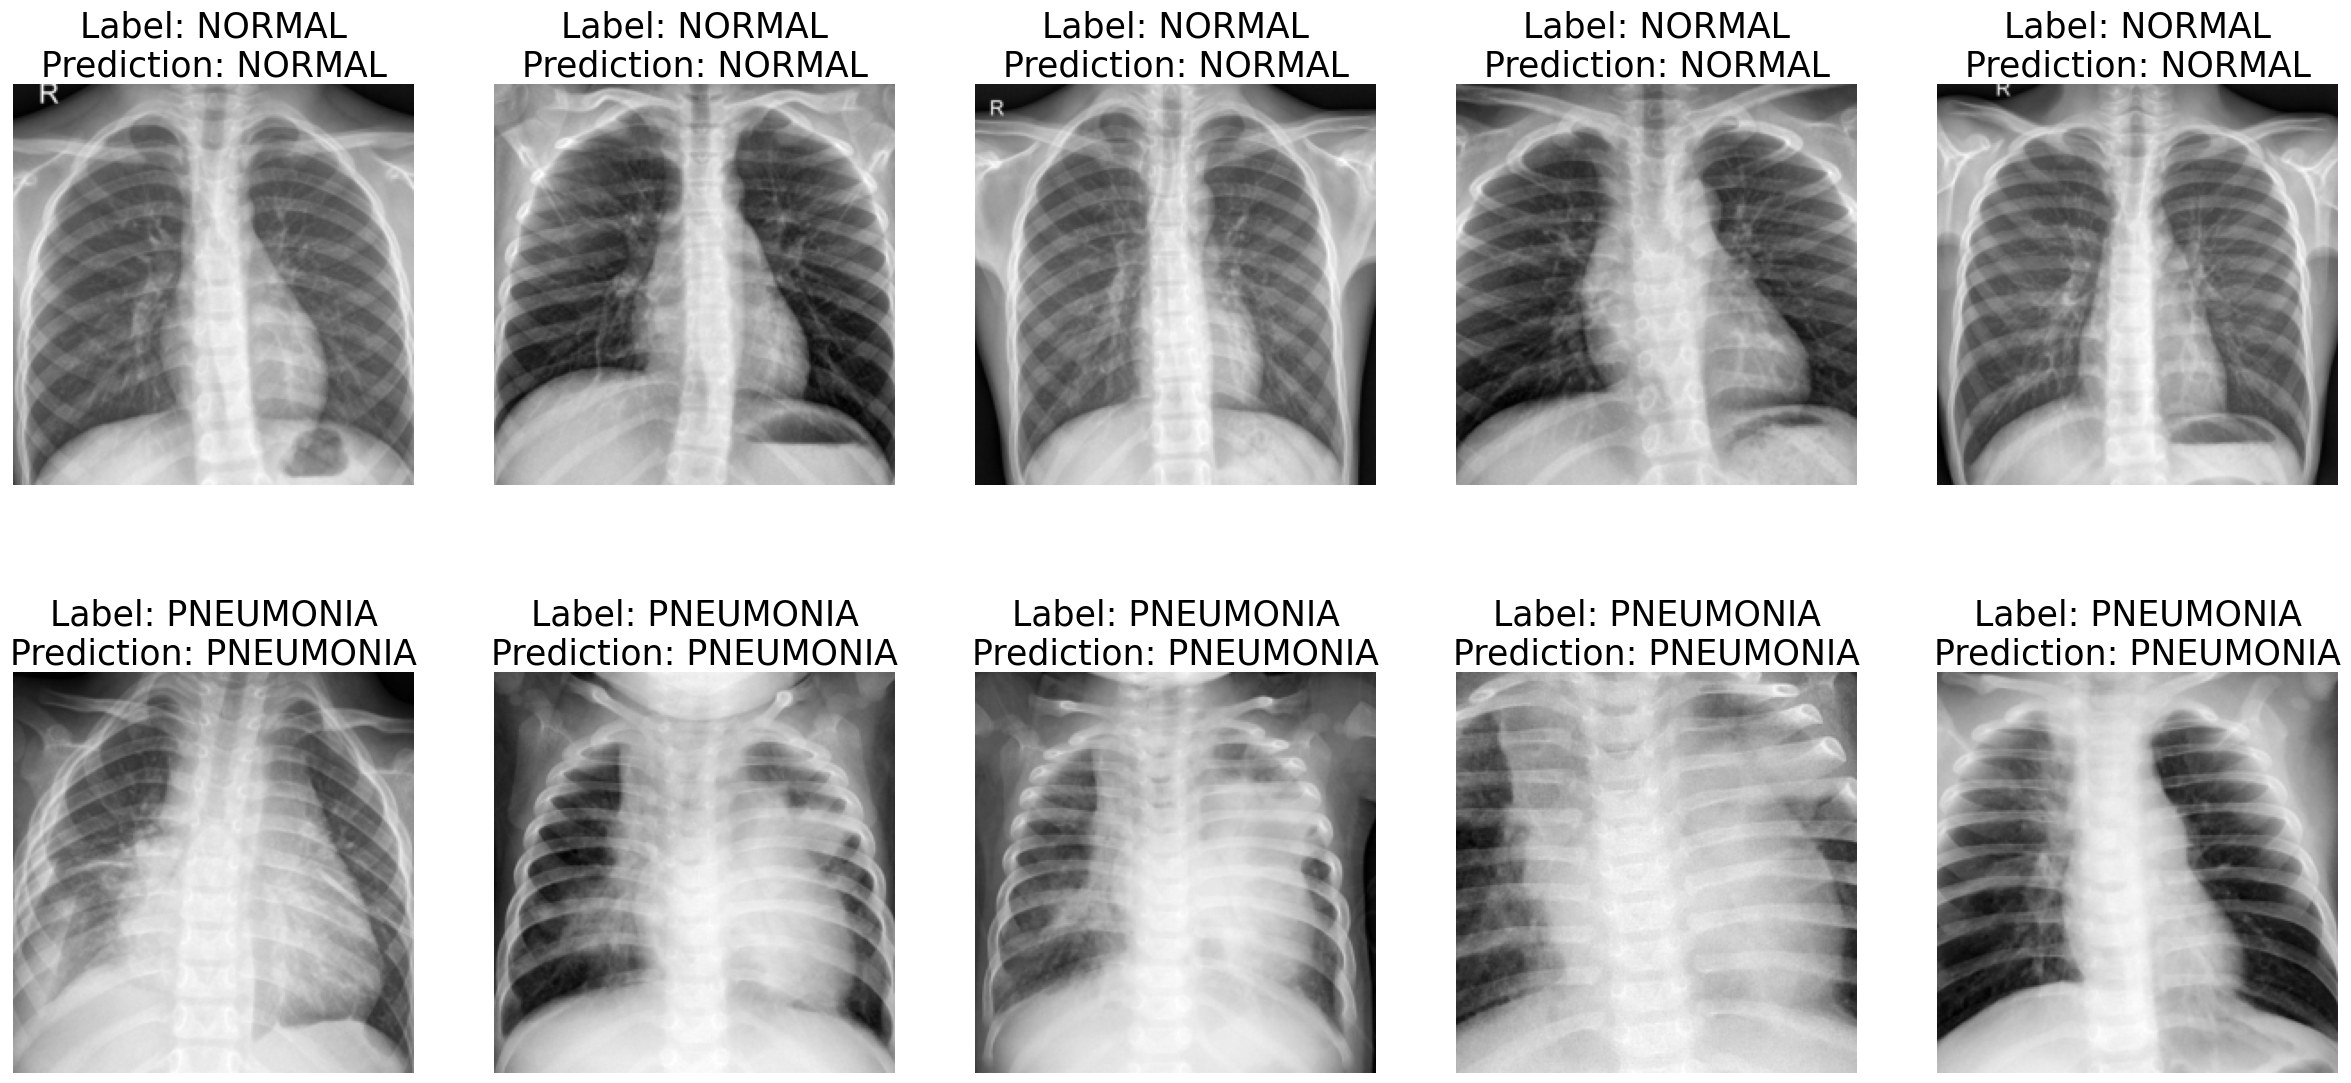

In [ ]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1),
                             np.arange(start=500, stop=505, step=1)))

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label],
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')
